# Time Analysis
* In this notebook, we look at the translation times DeepL and GPT4.1 had for the same tasks

In [45]:
from os.path import join
import pandas as pd
import json
import os

os.makedirs('time_results', exist_ok=True)

parts = ['ep-gpt', 'ep-deepl', 'flores-gpt', 'flores-deepl', 'opus-gpt', 'opus-deepl']

with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

for part in parts:
    data = {'Label':[], 'Time':[], 'Size':[]}
    for prefix, info in prefix2file.items():
        if prefix.startswith(part):
            src_lang, tgt_lang = prefix.split('-')[2], prefix.split('-')[3]
            duration = info['log']['end'] - info['log']['start']
            data['Label'].append(f'{src_lang}-{tgt_lang}')
            data['Time'].append(duration)
            if part.endswith('gpt'):
                data['Size'].append(info['log']['out_model_tokens'])
            if part.endswith('deepl'):
                data['Size'].append(info['log']['out_chars'])

            
    df = pd.DataFrame(data)
    df.to_csv(join('time_results', f'{part}.csv'))

In [46]:
from scripts.scoring import create_matrix_from_csv
import os
file2df = {f.replace('.csv', ''):{'file':join('time_results', f)} for f in os.listdir('time_results')}

for f, content in file2df.items():
    file_path = content['file']
    df = create_matrix_from_csv(file_path, metric='Time')
    file2df[f]['TIME'] = df
    file2df[f]['SIZE'] = create_matrix_from_csv(file_path, metric='Size')

## Statistics
* To compare this data more efficiently, it makes sense to employ techniques such as normalization

In [47]:
norm = {}
for f, content in file2df.items():
    df = content['TIME']
    normalized_df = (df - df.mean().mean()) / df.stack().std()
    norm[f] = normalized_df

ep-deepl


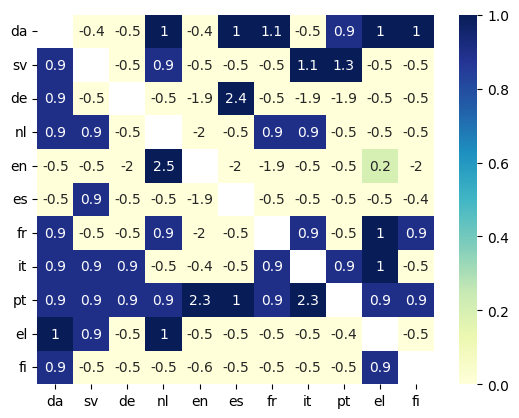


ep-gpt


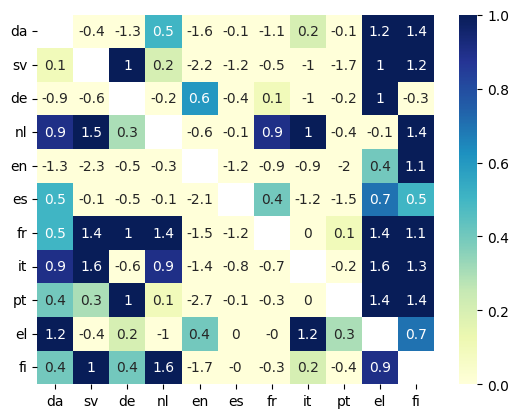


flores-deepl


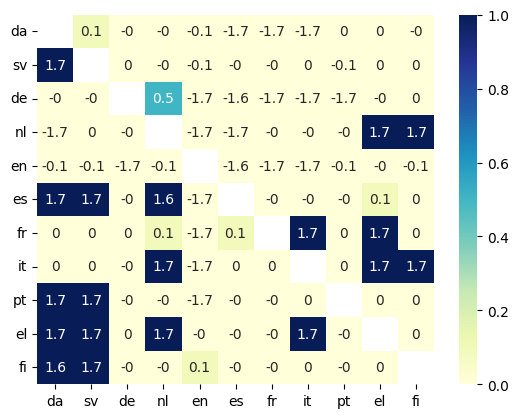


flores-gpt


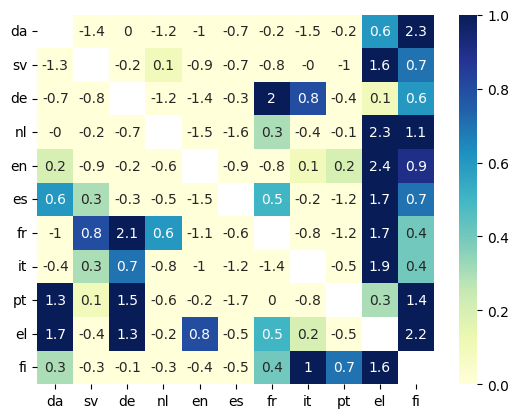


opus-deepl


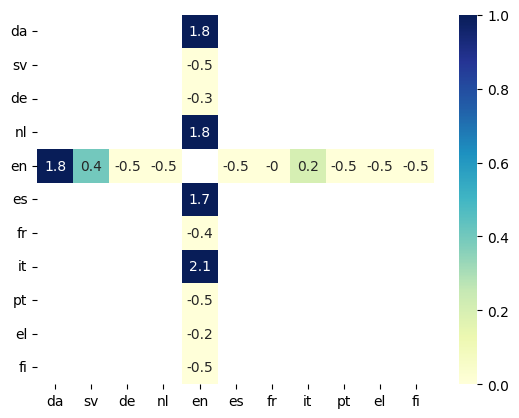


opus-gpt


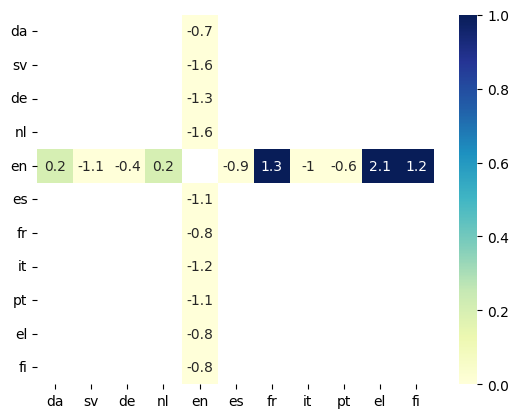

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
for key in norm:
    out = norm[key].round(1)
    out = out.reindex(index=order, columns=order)
    print(key)
    sns.heatmap(out, annot=True, cmap="YlGnBu", cbar=True, vmin=0, vmax=1)
    plt.yticks(rotation=0)
    plt.show()
    print()

In [49]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

parts = ['ep', 'flores', 'opus']

for part in parts:
    gpt = f'{part}-gpt'
    deepl = f'{part}-deepl'
    gpt_df = file2df[gpt]['TIME']
    deepl_df = file2df[deepl]['TIME']

    gpt_flat = gpt_df.values.flatten()
    deepl_flat = deepl_df.values.flatten()
    
    mask = ~np.isnan(gpt_flat) & ~np.isnan(deepl_flat)

    # Compute Pearson correlation
    print(part)
    corr, pval = pearsonr(gpt_flat[mask], deepl_flat[mask])
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:3f}")
    print()

ep
Pearson correlation: 0.19
p-value: 0.048976

flores
Pearson correlation: 0.28
p-value: 0.003265

opus
Pearson correlation: -0.26
p-value: 0.268835



In [50]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

parts = ['ep', 'flores', 'opus']

for part in parts:
    gpt = f'{part}-gpt'
    gpt_time = file2df[gpt]['TIME']
    gpt_size = file2df[gpt]['SIZE']

    gpt_time_flat = gpt_time.values.flatten()
    gpt_size_flat = gpt_size.values.flatten()

    mask = ~np.isnan(gpt_time_flat) & ~np.isnan(gpt_size_flat)

    # Compute Pearson correlation
    print(f'{part}-gpt')
    corr, pval = pearsonr(gpt_time_flat[mask], gpt_size_flat[mask])
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:3f}")
    print()

ep-gpt
Pearson correlation: 0.49
p-value: 0.000000

flores-gpt
Pearson correlation: 0.58
p-value: 0.000000

opus-gpt
Pearson correlation: 0.68
p-value: 0.000989



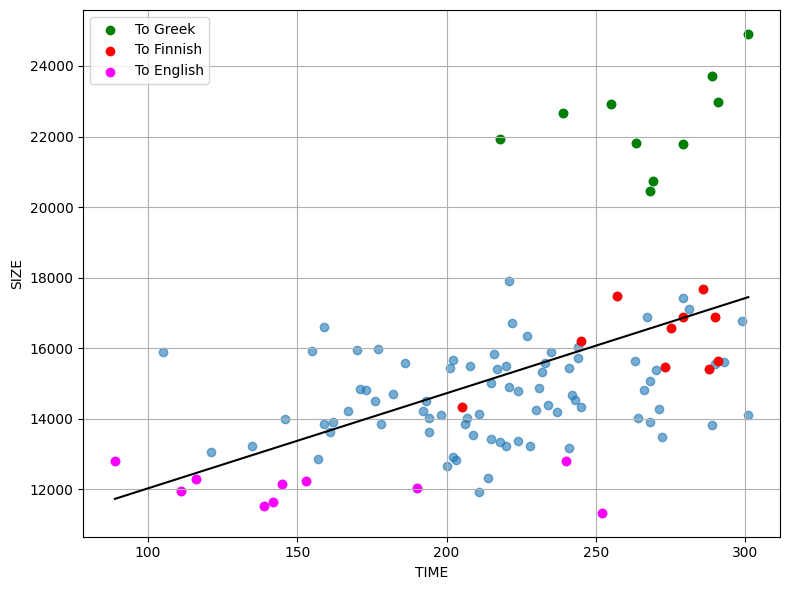

In [51]:
import matplotlib.pyplot as plt
# ChatGPT aided

gpt_time = file2df['ep-gpt']['TIME']
gpt_size = file2df['ep-gpt']['SIZE']


time_vals, size_vals = [], []
labels = []

for src in gpt_time.index:
    for tgt in gpt_time.columns:
        if src == tgt:
            continue
        bs = gpt_time.loc[src, tgt]
        cs = gpt_size.loc[src, tgt]
        time_vals.append(bs)
        size_vals.append(cs)
        labels.append(f'{src}-{tgt}')


time_np = np.array(time_vals)
size_np = np.array(size_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(time_vals, size_vals, alpha=0.6)

model = np.polyfit(time_np, size_np, 1)


x_line = np.linspace(min(time_np), max(time_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')

to_greek = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]
to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]
to_english = [idx for idx, pair in enumerate(labels) if pair.endswith('en')]


plt.scatter(
    time_np[to_greek],
    size_np[to_greek],
    color='green',
    label='To Greek'
)


plt.scatter(
    time_np[to_finnish],
    size_np[to_finnish],
    color='red',
    label='To Finnish'
)

plt.scatter(
    time_np[to_english],
    size_np[to_english],
    color='magenta',
    label='To English'
)



plt.xlabel("TIME")
plt.ylabel("SIZE")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [52]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_size = np.poly1d(model)(time_np)
residuals = abs(size_np - predicted_size)

top_n = 20
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {time_np[idx]:.1f}, {size_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

fi-de 241.0, 13168.00
da-pt 214.0, 12334.00
es-it 159.0, 16589.00
el-en 240.0, 12790.00
de-pt 211.0, 11919.00
fr-de 272.0, 13495.00
fr-nl 289.0, 13831.00
fi-nl 301.0, 14101.00
en-sv 105.0, 15881.00
sv-el 268.0, 20468.00
de-el 269.0, 20746.00
de-en 252.0, 11335.00
da-el 279.0, 21774.00
fi-el 263.3, 21806.00
fr-el 291.0, 22969.00
pt-el 289.0, 23709.00
nl-el 218.0, 21924.00
es-el 255.0, 22927.00
en-el 239.0, 22663.00
it-el 301.0, 24907.00


In [53]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

parts = ['ep', 'flores', 'opus']

for part in parts:
    gpt = f'{part}-deepl'
    gpt_time = file2df[gpt]['TIME']
    gpt_size = file2df[gpt]['SIZE']

    gpt_time_flat = gpt_time.values.flatten()
    gpt_size_flat = gpt_size.values.flatten()

    mask = ~np.isnan(gpt_time_flat) & ~np.isnan(gpt_size_flat)

    # Compute Pearson correlation
    print(f'{part}-gpt')
    corr, pval = pearsonr(gpt_time_flat[mask], gpt_size_flat[mask])
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:3f}")
    print()

ep-gpt
Pearson correlation: 0.07
p-value: 0.473528

flores-gpt
Pearson correlation: -0.04
p-value: 0.682992

opus-gpt
Pearson correlation: -0.11
p-value: 0.659046



C:\Users\Kokiri\AppData\Local\Temp\ipykernel_21152\3888255362.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


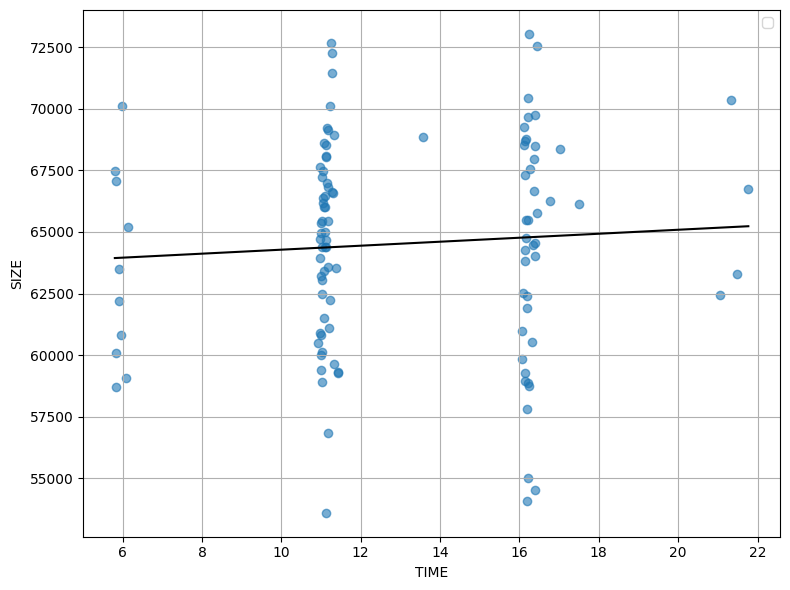

In [54]:
import matplotlib.pyplot as plt
# ChatGPT aided

gpt_time = file2df['ep-deepl']['TIME']
gpt_size = file2df['ep-deepl']['SIZE']


time_vals, size_vals = [], []
labels = []

box1 = []
box2 = []
box3 = []

for src in gpt_time.index:
    for tgt in gpt_time.columns:
        if src == tgt:
            continue
        bs = gpt_time.loc[src, tgt]
        cs = gpt_size.loc[src, tgt]
        time_vals.append(bs)
        size_vals.append(cs)
        label = f'{src}-{tgt}'
        labels.append(label)
        if bs < 8:
            box1.append(label)
        elif bs > 8 and bs < 12:
            box2.append(label)
        elif bs > 12 and bs < 18:
            box3.append(label)

time_np = np.array(time_vals)
size_np = np.array(size_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(time_vals, size_vals, alpha=0.6)

model = np.polyfit(time_np, size_np, 1)


x_line = np.linspace(min(time_np), max(time_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("TIME")
plt.ylabel("SIZE")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()